# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip install . --quiet

In [ ]:
!pip install protobuf==3.20.3

## Restart the Kernel
Restart the Kernel, and verify the protobuf version. 

In [1]:
import google.protobuf
print(google.protobuf.__version__)

3.20.3



## Instructions
The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Found path: /data/Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/data/Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/data/Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
#IF there is an error importing Torch, then install this
#!pip install torch==2.0.1 --quiet

In [33]:
import torch
import numpy as np
import copy
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class OUNoise:
    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()
    
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=BUFFER_SIZE)  # internal memory (deque)
        self.batch_size = BATCH_SIZE
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [27]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [28]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 1        # how often to update the network
UPDATE_COUNT = 1        # how many times to update the network each update step!
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
SEED = 12345

In [29]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, memory_, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed=SEED).to(device)
        self.actor_target = Actor(state_size, action_size, seed=SEED).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, seed=SEED).to(device)
        self.critic_target = Critic(state_size, action_size, seed=SEED).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size)

        # Replay memory
        self.memory = memory_
        
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward

        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                for i in range(UPDATE_COUNT):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, noise, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += noise*self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [30]:
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    total_scores = []
    noise = 1.0
    noise_reduction = 0.999

    actor_local = Actor(state_size, action_size, seed=10).to(device)
    actor_target = Actor(state_size, action_size, seed=10).to(device)
    actor_optimizer = optim.Adam(actor_local.parameters(), lr=LR_ACTOR)

    critic_local = Critic(state_size, action_size, seed=10).to(device)
    critic_target = Critic(state_size, action_size, seed=10).to(device)
    critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

    memory = ReplayBuffer(action_size, seed=SEED)
    
    agent = [Agent(state_size=state_size, 
                   action_size=action_size, 
                   memory_=memory, 
                   random_seed=SEED),
             Agent(state_size=state_size, 
                   action_size=action_size, 
                   memory_=memory, 
                   random_seed=SEED)]

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state_0 = env_info.vector_observations[0]
        state_1 = env_info.vector_observations[1]

        agent[0].reset()
        agent[1].reset()
        scores = np.zeros(num_agents)

        while True:
            action_0 = agent[0].act(state_0, noise, True)
            action_1 = agent[1].act(state_1, noise, True)
            action = [[action_0[0], action_0[1]], [action_1[0], action_1[1]]]
            noise *= noise_reduction

            env_info = env.step(action)[brain_name]
            next_state_0 = env_info.vector_observations[0]
            next_state_1 = env_info.vector_observations[1]

            dones = env_info.local_done

            agent[0].step(state_0, action_0, env_info.rewards[0], next_state_0, dones[0])
            agent[1].step(state_1, action_1, env_info.rewards[1], next_state_1, dones[1])

            state_0 = next_state_0
            state_1 = next_state_1

            scores += env_info.rewards

            if np.any(dones):
                break

        max_score = np.amax(scores)
        scores_deque.append(max_score)

        total_scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), max_score), end="")

        if np.mean(scores_deque) >= 0.5:
            print('\rEnvironment solved with: {} Episodes\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    return total_scores

In [37]:
scores = ddpg(n_episodes=2000)

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.00	Score: 0.00
Episode 500	Average Score: 0.00	Score: 0.00
Episode 600	Average Score: 0.00	Score: 0.00
Episode 700	Average Score: 0.01	Score: 0.09
Episode 800	Average Score: 0.02	Score: 0.00
Episode 900	Average Score: 0.05	Score: 0.09
Episode 1000	Average Score: 0.05	Score: 0.00
Episode 1100	Average Score: 0.06	Score: 0.00
Episode 1200	Average Score: 0.09	Score: 0.09
Episode 1300	Average Score: 0.16	Score: 0.10
Episode 1400	Average Score: 0.14	Score: 0.20
Episode 1500	Average Score: 0.33	Score: 2.00
Environment solved with: 1522 Episodes	Average Score: 0.50


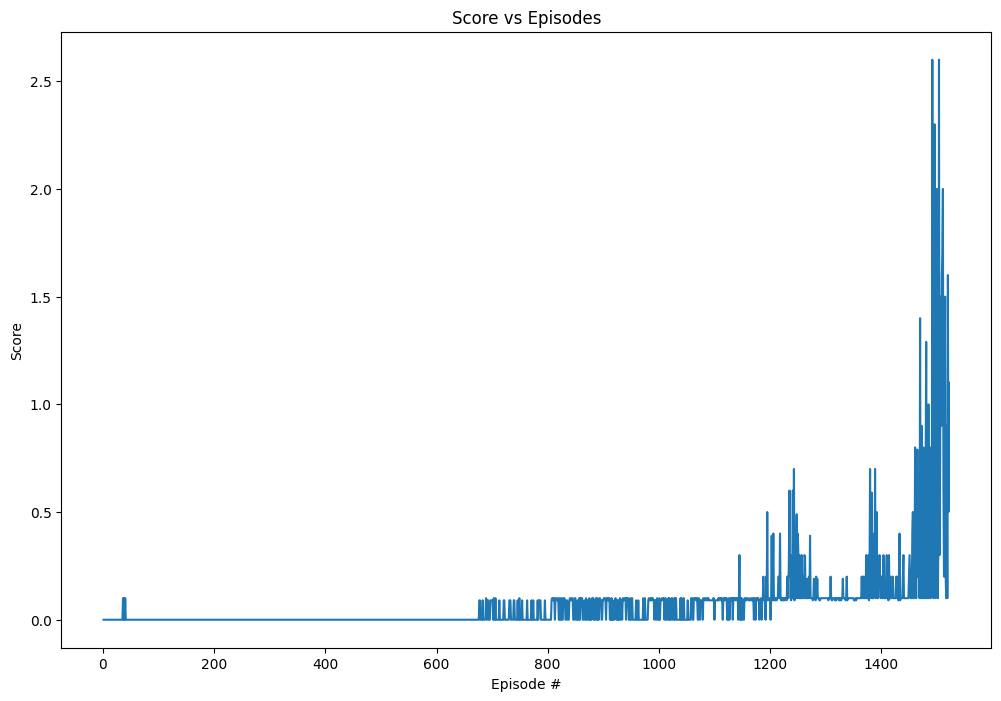

In [38]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score vs Episodes')
plt.show()